In [61]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import json
import os
import random
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
dict = {"word":"cat",
 "countrycode":"VE",
 "timestamp":"2017-03-02 23:25:10.07453 UTC",
 "recognized":True,
 "key_id":"5201136883597312",
 "drawing":[
   [
     [130,113,99,109,76,64,55,48,48,51,59,86,133,154,170,203,214,217,215,208,186,176,162,157,132],
     [72,40,27,79,82,88,100,120,134,152,165,184,189,186,179,152,131,114,100,89,76,0,31,65,70]
   ],[
     [76,28,7],
     [136,128,128]
   ],[
     [76,23,0],
     [160,164,175]
   ],[
     [87,52,37],
     [175,191,204]
   ],[
     [174,220,246,251],
     [134,132,136,139]
   ],[
     [175,255],
     [147,168]
   ],[
     [171,208,215],
     [164,198,210]
   ],[
     [130,110,108,111,130,139,139,119],
     [129,134,137,144,148,144,136,130]
   ],[
     [107,106],
     [96,113]
   ]
 ]
}

In [15]:
len(dict['drawing']), len(dict['drawing'][0]), len(dict['drawing'][0][0])

(9, 2, 25)

In [35]:
!gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"
!mkdir rnn_tutorial_data
!cd rnn_tutorial_data && gsutil -m cp "gs://quickdraw_dataset/full/simplified/*" .

gs://quickdraw_dataset/full/simplified/The Eiffel Tower.ndjson
gs://quickdraw_dataset/full/simplified/The Great Wall of China.ndjson
gs://quickdraw_dataset/full/simplified/The Mona Lisa.ndjson
gs://quickdraw_dataset/full/simplified/aircraft carrier.ndjson
gs://quickdraw_dataset/full/simplified/airplane.ndjson
gs://quickdraw_dataset/full/simplified/alarm clock.ndjson
gs://quickdraw_dataset/full/simplified/ambulance.ndjson
gs://quickdraw_dataset/full/simplified/angel.ndjson
gs://quickdraw_dataset/full/simplified/animal migration.ndjson
gs://quickdraw_dataset/full/simplified/ant.ndjson
gs://quickdraw_dataset/full/simplified/anvil.ndjson
gs://quickdraw_dataset/full/simplified/apple.ndjson
gs://quickdraw_dataset/full/simplified/arm.ndjson
gs://quickdraw_dataset/full/simplified/asparagus.ndjson
gs://quickdraw_dataset/full/simplified/axe.ndjson
gs://quickdraw_dataset/full/simplified/backpack.ndjson
gs://quickdraw_dataset/full/simplified/banana.ndjson
gs://quickdraw_dataset/full/simplified/ban

In [44]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  inkarray = sample["drawing"]
  stroke_lengths = [len(stroke[0]) for stroke in inkarray]
  total_points = sum(stroke_lengths)
  np_ink = np.zeros((total_points, 3), dtype=np.float32)
  current_t = 0
  for stroke in inkarray:
    for i in [0, 1]:
      np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
    current_t += len(stroke[0])
    np_ink[current_t - 1, 2] = 1  # stroke_end
  # Preprocessing.
  # 1. Size normalization.
  lower = np.min(np_ink[:, 0:2], axis=0)
  upper = np.max(np_ink[:, 0:2], axis=0)
  scale = upper - lower
  scale[scale == 0] = 1
  np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
  # 2. Compute deltas.
  np_ink = np_ink[1:, 0:2] - np_ink[0:-1, 0:2]
  return np_ink, class_name

In [64]:
with open("rnn_tutorial_data/The Eiffel Tower.ndjson", "r") as f:
    txt = f.readline()
    print("txt", txt)
    np_ink, class_name = parse_line(txt)
    print("np_ink", np_ink)
    print("class_name", class_name)

txt {"word":"The Eiffel Tower","countrycode":"GB","timestamp":"2017-03-11 14:47:44.05242 UTC","recognized":true,"key_id":"5027286841556992","drawing":[[[0,22,37,64,255],[218,220,227,228,211]],[[76,95,135,141,150,159,166,180,186,201],[220,138,31,0,63,79,117,150,191,224]],[[94,104,111,119,127,141,143,142,180,191],[212,167,149,80,59,41,30,134,202,232]],[[109,127,137,147,150,162,172,185],[122,120,104,97,99,124,128,128]],[[75,130,158],[162,159,150]]]}

np_ink [[ 0.08627451  0.00862068]
 [ 0.05882353  0.03017241]
 [ 0.10588236  0.00431037]
 [ 0.7490196  -0.07327586]
 [-0.7019608   0.03879309]
 [ 0.0745098  -0.35344827]
 [ 0.15686277 -0.4612069 ]
 [ 0.02352941 -0.1336207 ]
 [ 0.03529412  0.27155173]
 [ 0.03529412  0.06896552]
 [ 0.02745098  0.16379312]
 [ 0.05490196  0.14224136]
 [ 0.02352941  0.17672414]
 [ 0.05882353  0.14224136]
 [-0.41960785 -0.05172414]
 [ 0.03921568 -0.1939655 ]
 [ 0.02745098 -0.07758623]
 [ 0.03137255 -0.29741377]
 [ 0.03137255 -0.09051725]
 [ 0.05490199 -0.0775862 ]
 

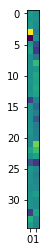

In [71]:
plt.imshow(np_ink)

In [102]:
def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_file,
                 classnames,
                 output_shards=10,
                 offset=0):
  """Convert training data from ndjson files into tf.Example in tf.Record.

  Args:
   trainingdata_dir: path to the directory containin the training data.
     The training data is stored in that directory as ndjson files.
   observations_per_class: the number of items to load per class.
   output_file: path where to write the output.
   classnames: array with classnames - is auto created if not passed in.
   output_shards: the number of shards to write the output in.
   offset: the number of items to skip at the beginning of each file.

  Returns:
    classnames: the class names as strings. classnames[classes[i]] is the
      textual representation of the class of the i-th data point.
  """

  def _pick_output_shard():
    return random.randint(0, output_shards - 1)

  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

  writers = []
  for i in range(FLAGS.output_shards):
    writers.append(
        tf.python_io.TFRecordWriter("%s-%05i-of-%05i" % (output_file, i,
                                                         output_shards)))

#   reading_order = range(len(file_handles)) * observations_per_class
  reading_order = np.arange(0, len(file_handles))
  random.shuffle(reading_order)

  for c in reading_order:
    line = file_handles[c].readline()
    ink = None
    while ink is None:
      ink, class_name = parse_line(line)
      if ink is None:
        print ("Couldn't parse ink from '" + line + "'.")
    if class_name not in classnames:
      classnames.append(class_name)
    features = {}
    features["class_index"] = tf.train.Feature(int64_list=tf.train.Int64List(
        value=[classnames.index(class_name)]))
    features["ink"] = tf.train.Feature(float_list=tf.train.FloatList(
        value=ink.flatten()))
    features["shape"] = tf.train.Feature(int64_list=tf.train.Int64List(
        value=ink.shape))
    f = tf.train.Features(feature=features)
    
    print(f)
    
    break



parser = argparse.ArgumentParser()
parser.register("type", "bool", lambda v: v.lower() == "true")
parser.add_argument(
  "--ndjson_path",
  type=str,
  default="/Users/we/PycharmProjects/models/tutorials/rnn/quickdraw/rnn_tutorial_data",
  help="Directory where the ndjson files are stored.")
parser.add_argument(
  "--output_path",
  type=str,
  default="/Users/we/PycharmProjects/models/tutorials/rnn/quickdraw/rnn_tutorial_data_parsed",
  help="Directory where to store the output TFRecord files.")
parser.add_argument(
  "--train_observations_per_class",
  type=int,
  default=10000,
  help="How many items per class to load for training.")
parser.add_argument(
  "--eval_observations_per_class",
  type=int,
  default=1000,
  help="How many items per class to load for evaluation.")
parser.add_argument(
  "--output_shards",
  type=int,
  default=10,
  help="Number of shards for the output.")

FLAGS, unparsed = parser.parse_known_args()

classnames = convert_data(
  FLAGS.ndjson_path,
  FLAGS.train_observations_per_class,
  os.path.join(FLAGS.output_path, "training.tfrecord"),
  classnames=[],
  output_shards=FLAGS.output_shards,
  offset=0)
# convert_data(
#   FLAGS.ndjson_path,
#   FLAGS.eval_observations_per_class,
#   os.path.join(FLAGS.output_path, "eval.tfrecord"),
#   classnames=classnames,
#   output_shards=FLAGS.output_shards,
#   offset=FLAGS.train_observations_per_class)

feature {
  key: "class_index"
  value {
    int64_list {
      value: 0
    }
  }
}
feature {
  key: "ink"
  value {
    float_list {
      value: 0.2235294133424759
      value: -0.04040402173995972
      value: 0.3176470696926117
      value: -0.010101020336151123
      value: 0.039215683937072754
      value: -0.015151500701904297
      value: 0.011764705181121826
      value: -0.050505101680755615
      value: -0.003921568393707275
      value: -0.08585858345031738
      value: -0.019607841968536377
      value: -0.04545450210571289
      value: -0.15294116735458374
      value: -0.02525252103805542
      value: -0.03529411554336548
      value: -0.03030306100845337
      value: -0.039215683937072754
      value: -0.35353535413742065
      value: 0.2666666507720947
      value: 0.06060606241226196
      value: 0.11372548341751099
      value: -0.0050505101680755615
      value: 0.07450979948043823
      value: -0.02020201086997986
      value: 0.00784313678741455
      value: -0.0